
# A Notebook to analyze hydrologic time-series data

## (Case study:  the Sauk-Suiattle Watershed )
<img src= "http://www.sauk-suiattle.com/images/Elliott.jpg"
style="float:left;width:150px;padding:20px">   
This data is compiled to digitally observe the Sauk-Suiattle Watershed, powered by HydroShare. <br />
<br />
Use this Jupyter Notebook to: <br />
Migrate data sets from prior data download events,
Compute daily, monthly, and annual temperature and precipitation statistics, <br /> 
Visualize precipitation results relative to the forcing data, <br />
Visualize the time-series trends among the gridded cells using different Gridded data products. <br />

<br /> <br /> <br /> <img src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png" style="float:right;width:120px;padding:20px">  
#### A Watershed Dynamics Model by the Watershed Dynamics Research Group in the Civil and Environmental Engineering Department at the University of Washington 

## 1.  HydroShare Setup and Preparation

To run this notebook, we must import several libaries. These are listed in order of 1) Python standard libraries, 2) hs_utils library provides functions for interacting with HydroShare, including resource querying, dowloading and creation, and 3) the observatory_gridded_hydromet library that is downloaded with this notebook. 

In [1]:
# data processing
import os
import pandas as pd, numpy as np, dask, json
import ogh

# data migration library
from utilities import hydroshare

# plotting and shape libraries
import matplotlib.pyplot as plt
%matplotlib inline

# silencing warning
import warnings
warnings.filterwarnings("ignore")

In [2]:
# initialize ogh_meta
meta_file = ogh.ogh_meta()

sorted(meta_file.keys())

['dailymet_bclivneh2013',
 'dailymet_livneh2013',
 'dailymet_livneh2015',
 'dailyvic_livneh2013',
 'dailyvic_livneh2015',
 'dailywrf_bcsalathe2014',
 'dailywrf_salathe2014']

In [3]:
# assemble the wateryear month indices
wateryear = [10,11,12,1,2,3,4,5,6,7,8,9]

# define Livneh et al., (2013) metadata
meta1 = meta_file['dailyvic_livneh2013']

# define Livneh et al., (2015) metadata
meta2 = meta_file['dailyvic_livneh2015']

# define overlapping time window
dr = ogh.overlappingDates(date_set1=tuple([meta1['start_date'], meta1['end_date']]), 
                          date_set2=tuple([meta2['start_date'], meta2['end_date']]))
dr

('1950-01-01', '2011-12-31')

Establish a secure connection with HydroShare by instantiating the hydroshare class that is defined within hs_utils. In addition to connecting with HydroShare, this command also sets and prints environment variables for several parameters that will be useful for saving work back to HydroShare. 

In [4]:
notebookdir = os.getcwd()

hs=hydroshare.hydroshare()
homedir = hs.getContentPath(os.environ["HS_RES_ID"])
os.chdir(homedir)
print('Data will be loaded from and save to:'+homedir)

Adding the following system variables:
   HS_USR_NAME = jphuong
   HS_RES_ID = 87dc5742cf164126a11ff45c3307fd9d
   HS_RES_TYPE = compositeresource
   JUPYTER_HUB_IP = jupyter.cuahsi.org

These can be accessed using the following command: 
   os.environ[key]

   (e.g.)
   os.environ["HS_USR_NAME"]  => jphuong
Successfully established a connection with HydroShare
Data will be loaded from and save to:/home/jovyan/work/notebooks/data/87dc5742cf164126a11ff45c3307fd9d/87dc5742cf164126a11ff45c3307fd9d/data/contents


If you are curious about where the data is being downloaded, click on the Jupyter Notebook dashboard icon to return to the File System view.  The homedir directory location printed above is where you can find the data and contents you will download to a HydroShare JupyterHub server.  At the end of this work session, you can migrate this data to the HydroShare iRods server as a Generic Resource. 

### Summarize the file availability from each watershed mapping file

In [5]:
# map the mappingfiles from usecase1
mappingfile1 = os.path.join(homedir,'Sauk_mappingfile.csv')

t1 = ogh.mappingfileSummary(listofmappingfiles = [mappingfile1], 
                            listofwatershednames = ['Sauk-Suiattle river'],
                            meta_file=meta_file)
t1

Watershed,Sauk-Suiattle river
Median elevation in meters [range](Number of gridded cells),1171[164-2216] (n=99)
dailymet_livneh2013,1171[164-2216] (n=99)
dailymet_bclivneh2013,1171[164-2216] (n=99)
dailymet_livneh2015,1171[164-2216] (n=99)
dailyvic_livneh2013,1171[164-2216] (n=99)
dailyvic_livneh2015,1171[164-2216] (n=99)
dailywrf_salathe2014,1171[164-2216] (n=99)
dailywrf_bcsalathe2014,1171[164-2216] (n=99)


In [6]:
files=[]
files.append(mappingfile1)

## 3.  Compare Hydrometeorology 

This section performs computations and generates plots of the Livneh 2013, Livneh 2016, and WRF 2014 temperature and precipitation data in order to compare them with each other and observations. The generated plots are automatically downloaded and saved as .png files in the "plots" folder of the user's home directory and inline in the notebook.

In [7]:
# # two lowest elevation locations
lowE_ref = ogh.findCentroidCode(mappingfile=mappingfile1, colvar='ELEV', colvalue=164)

# one highest elevation location
highE_ref = ogh.findCentroidCode(mappingfile=mappingfile1, colvar='ELEV', colvalue=2216)

# combine references together
reference_lines = highE_ref + lowE_ref
reference_lines

[(69, 48.09375, -121.09375),
 (3, 48.46875, -121.59375),
 (24, 48.34375, -121.53125)]

## 2. Get list of gridded climate points for the watershed

This example uses a shapefile with the watershed boundary of the Sauk-Suiattle Basin, which is stored in HydroShare at the following url: https://www.hydroshare.org/resource/c532e0578e974201a0bc40a37ef2d284/. 

The data for our processing routines can be retrieved using the getResourceFromHydroShare function by passing in the global identifier from the url above.  In the next cell, we download this resource from HydroShare, and identify that the points in this resource are available for downloading gridded hydrometeorology data, based on the point shapefile at https://www.hydroshare.org/resource/ef2d82bf960144b4bfb1bae6242bcc7f/, which is for the extent of North America and includes the average elevation for each 1/16 degree grid cell.  The file must include columns with station numbers, latitude, longitude, and elevation. The header of these columns must be FID, LAT, LONG_, and ELEV or RASTERVALU, respectively. The station numbers will be used for the remainder of the code to uniquely reference data from each climate station, as well as to identify minimum, maximum, and average elevation of all of the climate stations.  The webserice is currently set to a URL for the smallest geographic overlapping extent - e.g. WRF for Columbia River Basin (to use a limit using data from a FTP service, treatgeoself() would need to be edited in observatory_gridded_hydrometeorology utility). 

In [8]:
"""
Sauk
"""
# Watershed extent
hs.getResourceFromHydroShare('c532e0578e974201a0bc40a37ef2d284')
sauk = hs.content['wbdhub12_17110006_WGS84_Basin.shp']

# reproject the shapefile into WGS84
ogh.reprojShapefile(sourcepath=sauk)

This resource already exists in your userspace.
c532e0578e974201a0bc40a37ef2d284/
|-- c532e0578e974201a0bc40a37ef2d284/
|   |-- bagit.txt
|   |-- manifest-md5.txt
|   |-- readme.txt
|   |-- tagmanifest-md5.txt
|   |-- data/
|   |   |-- resourcemap.xml
|   |   |-- resourcemetadata.xml
|   |   |-- contents/
|   |   |   |-- wbdhub12_17110006_WGS84_Basin.cpg
|   |   |   |-- wbdhub12_17110006_WGS84_Basin.shp
|   |   |   |-- wbdhub12_17110006_WGS84_Basin.shx
|   |   |   |-- wbdhub12_17110006_WGS84_Basin.dbf
|   |   |   |-- wbdhub12_17110006_WGS84_Basin.prj
|   |   |   |-- wbdhub12_17110006_WGS84_Basin_2.shp
|   |   |   |-- wbdhub12_17110006_WGS84_Basin_2.shx
|   |   |   |-- wbdhub12_17110006_WGS84_Basin_2.dbf
|   |   |   |-- wbdhub12_17110006_WGS84_Basin_2.cpg
|   |   |   |-- wbdhub12_17110006_WGS84_Basin_2.prj

Do you want to overwrite these data [Y/n]? n


In [9]:
# establish the Sauk-Suiattle watershed surface area
# e.g., Sauk-Suiattle is estimated at 714 square miles
Sauk_sq_meters = ogh.computeSurfaceArea(sauk)
Sauk_sq_feet = Sauk_sq_meters*10.7639 # sq meters to sq feet
Sauk_sq_feet

array([  2.04128569e+10])

<Figure size 1000x1000 with 0 Axes>

### INPUT: gridded meteorology from Jupyter Hub folders
Data frames for each set of data are stored in a dictionary. The inputs to gridclim_dict() include the folder location and name of the hydrometeorology data, the file start and end, the analysis start and end, and the elevation band to be included in the analsyis (max and min elevation). <br/>  

#### Create a dictionary of climate variables for the long-term mean (ltm) using the default elevation option of calculating a high, mid, and low elevation average.  The dictionary here is initialized with the Livneh et al., 2013 dataset with a dictionary output 'ltm_3bands', which is used as an input to the second time we run gridclim_dict(), to add the Salathe et al., 2014 data to the same dictionary. 

## Explore the VIC metadata and data 

In [10]:
# display Livneh et al. (2013) metadata
pd.DataFrame.from_dict(meta1['variable_info']).T.loc[meta1['variable_list']]

,desc,dtypes,units
YEAR,year,int8,yr
MONTH,month,int8,mo
DAY,day,int8,day
EVAP,"Total ET rate-- includes Canopy, Sub-canopy E...",float64,mm/s
RUNOFF,Runoff,float64,mm/s
BASEFLOW,Baseflow,float64,mm/s
SMTOP,Soil moisture top layer,float64,mm
SMMID,Soil moisture middle layer,float64,mm
SMBOT,Soil moisture bottom layer,float64,mm
SWE,Snow water equivalent (SWE),float64,mm


In [11]:
# display Livneh et al. (2015) metadata
pd.DataFrame.from_dict(meta2['variable_info']).T.loc[meta2['variable_list']]

,desc,dtypes,units
YEAR,year,int8,yr
MONTH,month,int8,mo
DAY,day,int8,day
EVAP,"Total ET rate-- includes Canopy, Sub-canopy E...",float64,mm/day
RUNOFF,Runoff,float64,mm/day
BASEFLOW,Baseflow,float64,mm/day
SMTOP,Soil moisture top layer,float64,mm
SMMID,Soil moisture middle layer,float64,mm
SMBOT,Soil moisture bottom layer,float64,mm
SWE,Snow water equivalent (SWE),float64,mm


In [12]:
%%time
# read in livneh et al. (2013) VIC
ltm = ogh.gridclim_dict(mappingfile=mappingfile1,
                        metadata=meta_file,
                        variable_list=['BASEFLOW','RUNOFF'],
                        dataset='dailyvic_livneh2013',
                        subset_start_date=dr[0],
                        subset_end_date=dr[1])

Number of data files within elevation range (164.0-2216.0 m): 99
RUNOFF dataframe reading complete:0:00:02.895005
BASEFLOW dataframe reading complete:0:00:05.072465
RUNOFF_dailyvic_livneh2013 calculations completed in 0:00:00.074879
BASEFLOW_dailyvic_livneh2013 calculations completed in 0:00:00.064447
CPU times: user 28 s, sys: 36.4 s, total: 1min 4s
Wall time: 5.22 s


In [13]:
%%time
# read in livneh et al. (2015) VIC
ltm = ogh.gridclim_dict(mappingfile=mappingfile1,
                        metadata=meta_file,
                        variable_list=['BASEFLOW','RUNOFF'],
                        dataset='dailyvic_livneh2015',
                        subset_start_date=dr[0],
                        subset_end_date=dr[1],
                        df_dict=ltm)

Number of data files within elevation range (164.0-2216.0 m): 99
RUNOFF dataframe reading complete:0:00:01.840227
BASEFLOW dataframe reading complete:0:00:03.220655
RUNOFF_dailyvic_livneh2015 calculations completed in 0:00:00.067284
BASEFLOW_dailyvic_livneh2015 calculations completed in 0:00:00.058400
CPU times: user 15.6 s, sys: 3.71 s, total: 19.3 s
Wall time: 3.36 s


In [14]:
# compute daily streamflow as the sum of the daily Baseflow and Runoff 
ltm['POTRUNOFF_dailyvic_livneh2013']=ltm['BASEFLOW_dailyvic_livneh2013']+ltm['RUNOFF_dailyvic_livneh2013']
ltm['POTRUNOFF_dailyvic_livneh2015']=ltm['BASEFLOW_dailyvic_livneh2015']+ltm['RUNOFF_dailyvic_livneh2015']

In [15]:
# convert the Livneh et al. (2013) VIC runoff from mm/s to mm/day units
ltm['POTRUNOFF_dailyvic_livneh2013'] = ltm['POTRUNOFF_dailyvic_livneh2013'].apply(lambda x: ogh.sec_to_day(x))

In [16]:
# compute sums and mean monthly an yearly sums
ltm = ogh.aggregate_space_time_sum(df_dict=ltm,
                                   suffix='POTRUNOFF_dailyvic_livneh2013',
                                   start_date=dr[0],
                                   end_date=dr[1])
ltm = ogh.aggregate_space_time_sum(df_dict=ltm,
                                   suffix='POTRUNOFF_dailyvic_livneh2015',
                                   start_date=dr[0],
                                   end_date=dr[1])

POTRUNOFF_dailyvic_livneh2013 calculations completed in 0:00:00.257017
POTRUNOFF_dailyvic_livneh2015 calculations completed in 0:00:00.253641


In [17]:
# read in Discharge data from USGS staton (Sauk river near Sauk, WA)
usgs_obs = pd.read_csv('https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=12189500&referred_module=sw&period=&begin_date=1950-01-01&end_date=2011-12-31',
                       sep='\t',
                       skiprows=29,
                       header=None,
                       names=['agency_cd','site_no','datetime','discharge_cfs','data_quality_code'],
                       parse_dates=[2]).set_index(['datetime'])

usgs_obs.head(10)

,agency_cd,site_no,discharge_cfs,data_quality_code
datetime,,,,
1950-01-01,USGS,12189500,4870,A
1950-01-02,USGS,12189500,4130,A
1950-01-03,USGS,12189500,3680,A
1950-01-04,USGS,12189500,3680,A
1950-01-05,USGS,12189500,3250,A
1950-01-06,USGS,12189500,3150,A
1950-01-07,USGS,12189500,2950,A
1950-01-08,USGS,12189500,2760,A
1950-01-09,USGS,12189500,2570,A


In [18]:
%%time 

# convert discharge into mm/day
usgs_obs['discharge_mmday'] = usgs_obs['discharge_cfs'].apply(lambda x: ogh.cfs_to_mmday(cfs=x, SA_sq_ft=Sauk_sq_feet))

# create a dataframe with daily discharge from a single location
ltm['discharge_SaukRiverNearSauk'] = usgs_obs.loc[:,['discharge_mmday']]

# compute spatial-temporal statistics
ltm = ogh.aggregate_space_time_sum(df_dict=ltm,
                                   suffix='discharge_SaukRiverNearSauk',
                                   start_date=dr[0],
                                   end_date=dr[1])

discharge_SaukRiverNearSauk calculations completed in 0:00:06.609339
CPU times: user 7.28 s, sys: 630 ms, total: 7.91 s
Wall time: 7.01 s


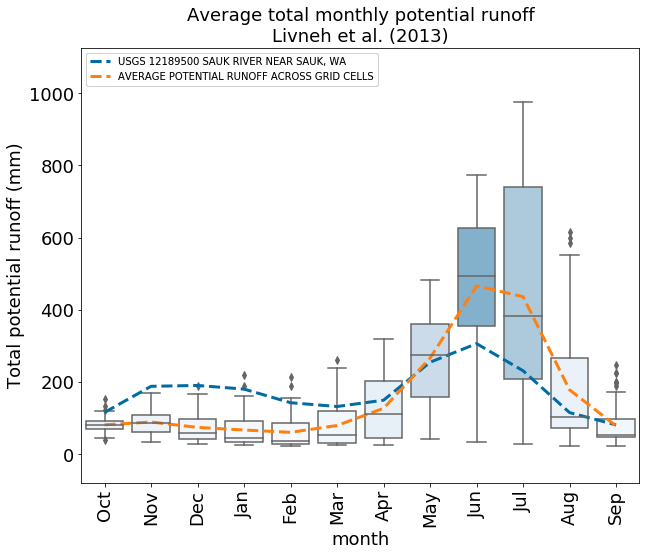

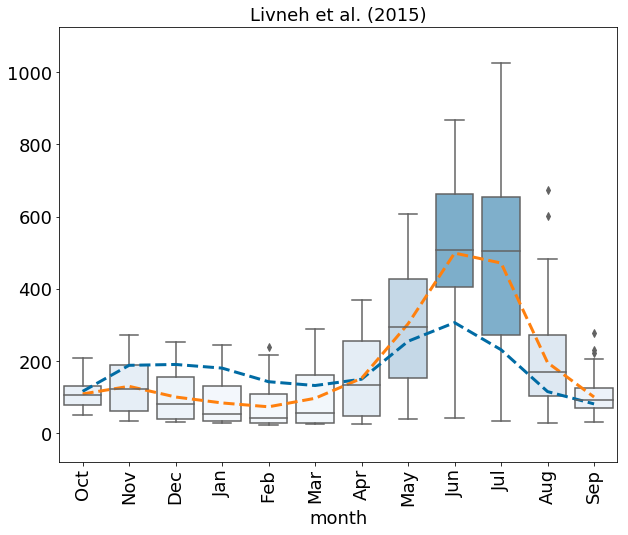

In [31]:
# plot the mean of monthly sum of daily potential runoff
vr = ogh.valueRange([ltm['meanbymonthsum_POTRUNOFF_dailyvic_livneh2013'],
                     ltm['meanbymonthsum_POTRUNOFF_dailyvic_livneh2015'],
                     ltm['meanbymonthsum_discharge_SaukRiverNearSauk'],
                     ltm['meanmonthsum_POTRUNOFF_dailyvic_livneh2013']])

outfile=os.path.join(homedir, 'meanbymonthsum_POTRUNOFF_dailyvic_livneh2013.png')
files.append(outfile)
ax1 = ogh.renderValueInBoxplot(vardf=ltm['meanbymonthsum_POTRUNOFF_dailyvic_livneh2013'],
                               vmax=vr.max()+1,
                               vmin=vr.min()-1,
                               outfilepath=outfile,
                               plottitle='Average total monthly potential runoff\nLivneh et al. (2013)',
                               time_steps='month',
                               wateryear=True,
                               value_name='Total potential runoff (mm)',
                               cmap='Blues',
                               figsize=(10,8),
                               obs_datavector=[ltm['meanbymonthsum_discharge_SaukRiverNearSauk'].loc[wateryear].reset_index(drop=True),
                                               ltm['meanmonthsum_POTRUNOFF_dailyvic_livneh2013'].loc[wateryear].reset_index(drop=True)],
                               obs_datalabel=['USGS 12189500 SAUK RIVER NEAR SAUK, WA',
                                              'AVERAGE POTENTIAL RUNOFF ACROSS GRID CELLS'],
                               obs_legend_loc=2,
                               ref_legend=False)

outfile=os.path.join(homedir, 'meanbymonthsum_POTRUNOFF_dailyvic_livneh2015.png')
files.append(outfile)
ax2 = ogh.renderValueInBoxplot(vardf=ltm['meanbymonthsum_POTRUNOFF_dailyvic_livneh2015'],
                               vmax=vr.max()+1,
                               vmin=vr.min()-1,
                               outfilepath=outfile,
                               plottitle='Livneh et al. (2015)',
                               time_steps='month',
                               wateryear=True,
                               value_name='',
                               cmap='Blues',
                               figsize=(10,8),
                               obs_datavector=[ltm['meanbymonthsum_discharge_SaukRiverNearSauk'].loc[wateryear].reset_index(drop=True),
                                               ltm['meanmonthsum_POTRUNOFF_dailyvic_livneh2015'].loc[wateryear].reset_index(drop=True)],
                               obs_datalabel=['USGS 12189500 SAUK RIVER NEAR SAUK, WA', 
                                              'AVERAGE POTENTIAL RUNOFF ACROSS GRID CELLS'],
                               obs_legend_loc=2,
                               obs_legend=False,
                               ref_legend=False)

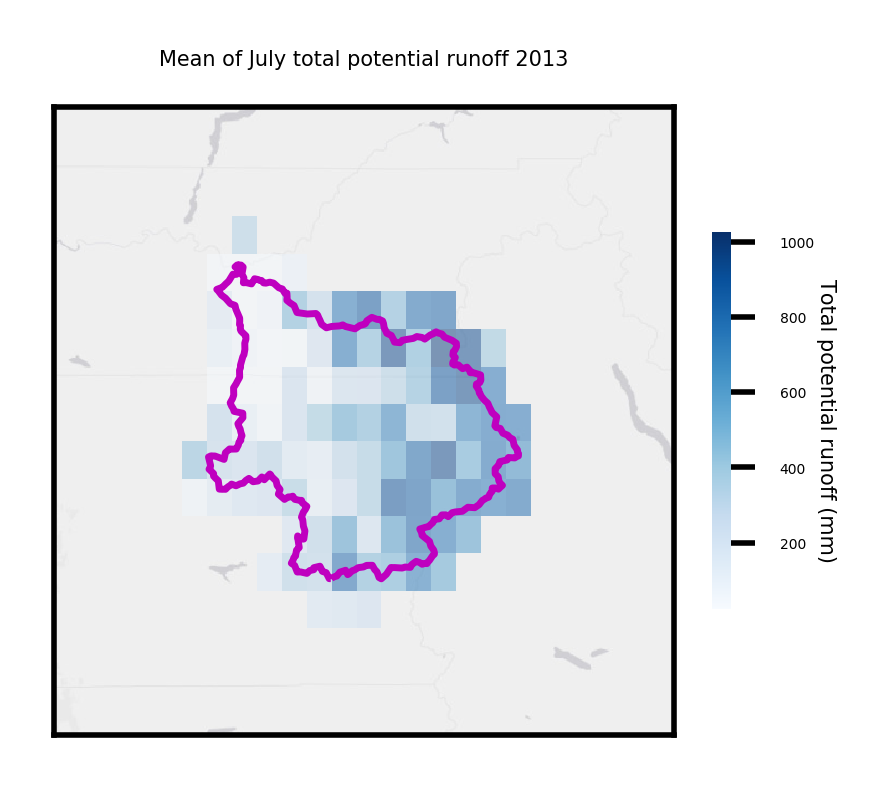

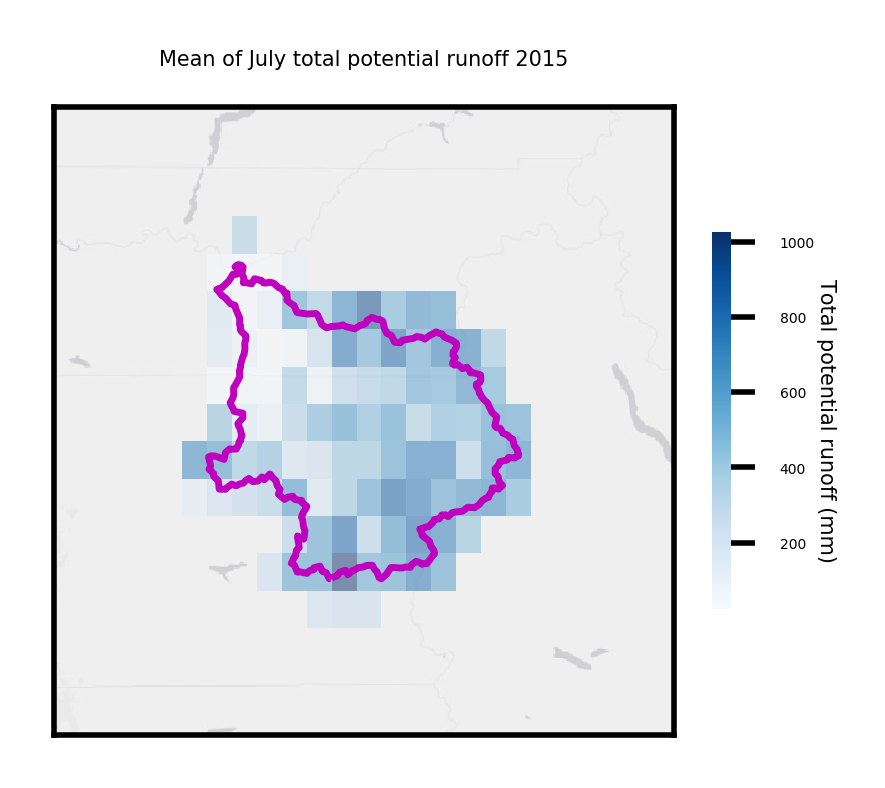

In [30]:
# loop through each month to compute the 10% Exceedance Probability
for eachmonth in [7]:
    monthlabel = pd.datetime.strptime(str(eachmonth), '%m')
    
    # render spatial map
    outfile=os.path.join(homedir,'meanbymonthsum_{0}_POTRUNOFF_dailyvic_livneh2013.png'.format(monthlabel.strftime('%b')))
    files.append(outfile)
    ogh.renderValuesInPoints(vardf=ltm['meanbymonthsum_POTRUNOFF_dailyvic_livneh2013'],
                             vmax=vr.max()+1,
                             vmin=vr.min()-1,
                             vardf_dateindex=eachmonth, 
                             shapefile=sauk,
                             outfilepath=outfile,
                             plottitle='Mean of {0} total potential runoff 2013'.format(monthlabel.strftime('%B')),
                             colorbar_label='Total potential runoff (mm)',
                             basemap_image='Canvas/World_Light_Gray_Base',
                             cmap='Blues',
                             figsize=(2,2))
    
    # render spatial map
    outfile=os.path.join(homedir,'meanbymonthsum_{0}_POTRUNOFF_dailyvic_livneh2015.png'.format(monthlabel.strftime('%b')))
    files.append(outfile)
    ogh.renderValuesInPoints(vardf=ltm['meanbymonthsum_POTRUNOFF_dailyvic_livneh2015'],
                             vmax=vr.max()+1,
                             vmin=vr.min()-1,
                             vardf_dateindex=eachmonth, 
                             shapefile=sauk,
                             outfilepath=outfile, 
                             plottitle='Mean of {0} total potential runoff 2015'.format(monthlabel.strftime('%B')),
                             colorbar_label='Total potential runoff (mm)',
                             basemap_image='Canvas/World_Light_Gray_Base',
                             cmap='Blues',
                             figsize=(2,2))

In [34]:
# Compute monthly 10% Exceedance Probability Thresholds

# Livneh et al. (2013)
ltm = ogh.monthlyExceedence_mmday(df_dict=ltm,
                                  daily_streamflow_dfname='POTRUNOFF_dailyvic_livneh2013',
                                  exceedance=10)

# Livneh et al. (2015)
ltm = ogh.monthlyExceedence_mmday(df_dict=ltm,
                                  daily_streamflow_dfname='POTRUNOFF_dailyvic_livneh2015',
                                  exceedance=10)

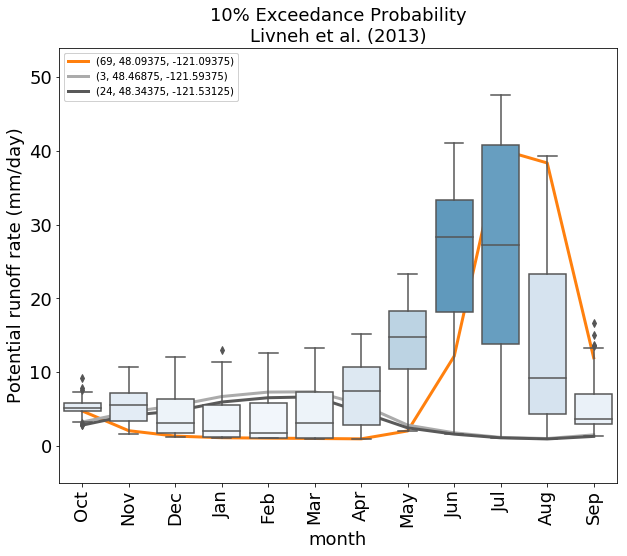

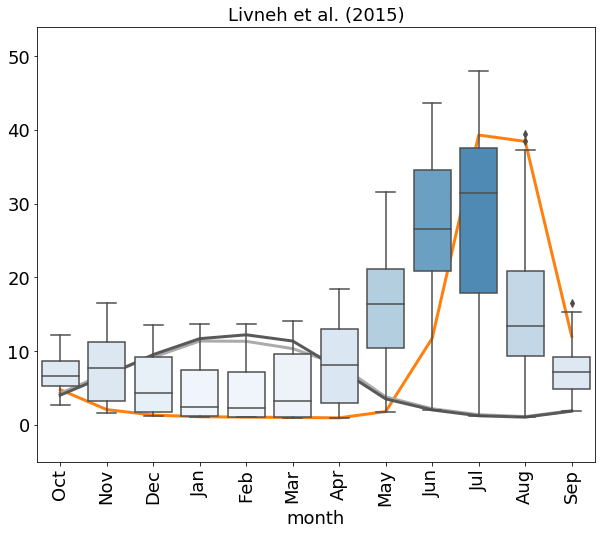

In [35]:
# plot the distribution of total monthly precipitation by across stations

# consider value ranges
vr = ogh.valueRange([ltm['EXCEED10_mmday_dailyvic_livneh2013'],
                     ltm['EXCEED10_mmday_dailyvic_livneh2015']])

# render monthly exceedance probability distributions for Livneh et al. (2013)
outfile=os.path.join(homedir, 'SaukExceedance{0}_livneh2013.png'.format(10))
files.append(outfile)
ax3 = ogh.renderValueInBoxplot(vardf=ltm['EXCEED{0}_mmday_dailyvic_livneh2013'.format(10)],
                               vmin=vr.min()-1,
                               vmax=vr.max()+1,
                               outfilepath=outfile,
                               plottitle='10% Exceedance Probability\nLivneh et al. (2013)',
                               time_steps='month',
                               wateryear=True,
                               value_name='Potential runoff rate (mm/day)',
                               cmap='Blues',
                               figsize=(10,8),
                               reference_lines=reference_lines,
                               ref_legend_loc=2,
                               ref_legend=True,
                               obs_datavector=[0],
                               obs_datalabel=[' '])


# render monthly exceedance probability distributions for Livneh et al. (2015)
outfile=os.path.join(homedir, 'SaukExceedance{0}_livneh2015.png'.format(10))
files.append(outfile)
ax4 = ogh.renderValueInBoxplot(vardf=ltm['EXCEED{0}_mmday_dailyvic_livneh2015'.format(10)],
                               vmin=vr.min()-1,
                               vmax=vr.max()+1,
                               outfilepath=outfile,
                               plottitle='Livneh et al. (2015)',
                               time_steps='month',
                               wateryear=True,
                               value_name='',
                               cmap='Blues',
                               figsize=(10,8),
                               reference_lines=reference_lines,
                               ref_legend_loc=2,
                               ref_legend=False,
                               obs_datavector=[0],
                               obs_datalabel=[' '],
                               obs_legend=False)

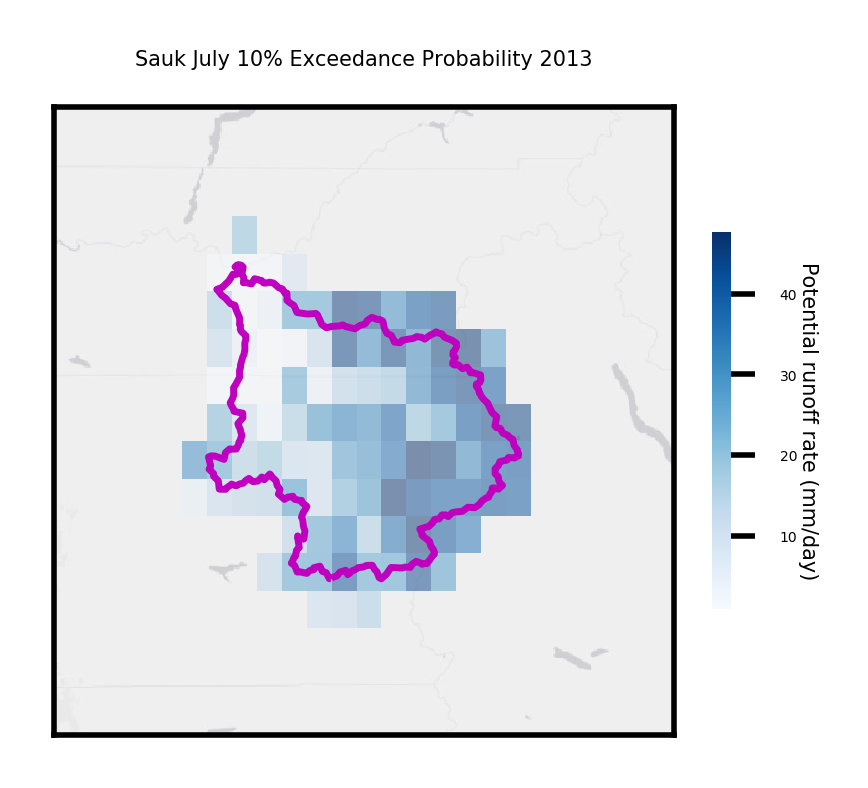

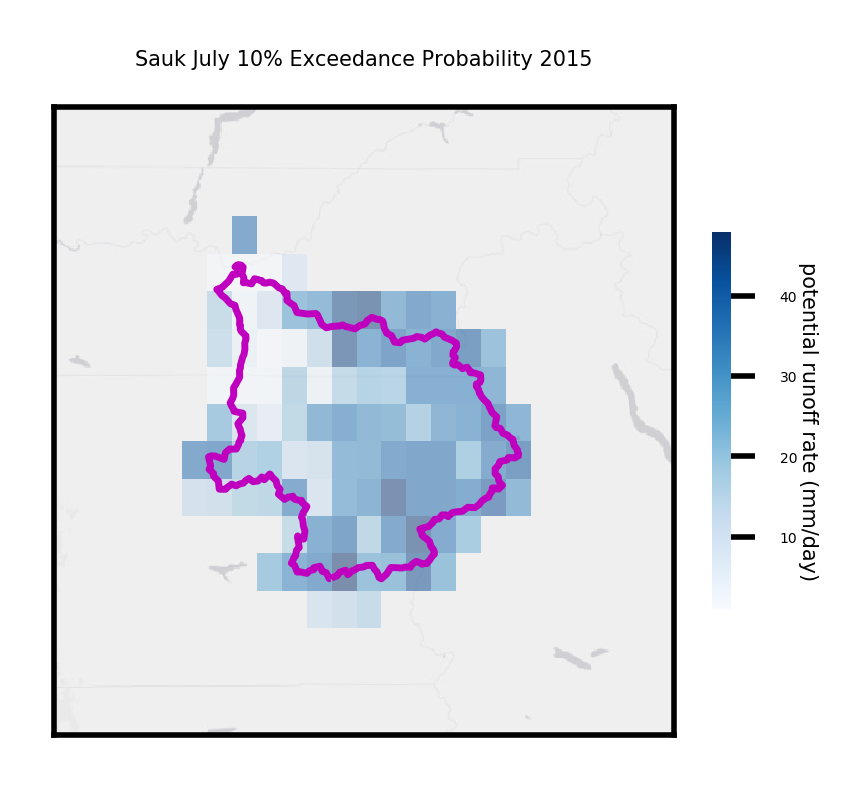

In [36]:
# loop through each month to compute the 10% Exceedance Probability
for eachmonth in [7]:
    monthlabel = pd.datetime.strptime(str(eachmonth), '%m')

    # render spatial map
    outfile=os.path.join(homedir,'sauk{0}exceed10_livneh2013.png'.format(monthlabel.strftime('%b')))
    files.append(outfile)
    ogh.renderValuesInPoints(vardf=ltm['EXCEED10_mmday_dailyvic_livneh2013'],
                             vardf_dateindex=eachmonth, 
                             shapefile=sauk,
                             outfilepath=outfile, 
                             plottitle='Sauk {0} 10% Exceedance Probability 2013'.format(monthlabel.strftime('%B')),
                             colorbar_label='Potential runoff rate (mm/day)',
                             basemap_image='Canvas/World_Light_Gray_Base',
                             cmap='Blues')
    
    # render spatial map
    outfile=os.path.join(homedir,'sauk{0}exceed10_livneh2015.png'.format(monthlabel.strftime('%b')))
    files.append(outfile)
    ogh.renderValuesInPoints(vardf=ltm['EXCEED10_mmday_dailyvic_livneh2015'],
                             vardf_dateindex=eachmonth, 
                             shapefile=sauk,
                             outfilepath=outfile, 
                             plottitle='Sauk {0} 10% Exceedance Probability 2015'.format(monthlabel.strftime('%B')),
                             colorbar_label='potential runoff rate (mm/day)',
                             basemap_image='Canvas/World_Light_Gray_Base',
                             cmap='Blues')

## 10. Save the results back into HydroShare
<a name="creation"></a>

Using the `hs_utils` library, the results of the Geoprocessing steps above can be saved back into HydroShare.  First, define all of the required metadata for resource creation, i.e. *title*, *abstract*, *keywords*, *content files*.  In addition, we must define the type of resource that will be created, in this case *genericresource*.  

***Note:*** Make sure you save the notebook at this point, so that all notebook changes will be saved into the new HydroShare resource.

In [25]:
# save the dictionary of dataframes
outfile=os.path.join(homedir, 'ltm_vicExceedance.json')
files.append(outfile)

ogh.saveDictOfDf(dictionaryObject=ltm, outfilepath=outfile)

len(files)

10

In [ ]:
# for each file downloaded onto the server folder, move to a new HydroShare Generic Resource
title = 'Exceedance Probability within Sauk-Suiattle'
abstract = 'This the output from the TreatGeoSelf utility integration notebook.'
keywords = ['Sauk', 'climate', 'Streamflow','flood risk prediction','hydromet','watershed'] 
rtype = 'genericresource'  

# create the new resource
resource_id = hs.createHydroShareResource(title=title,
                                          abstract=abstract,
                                          keywords=keywords,
                                          resource_type=rtype,
                                          content_files=files,
                                          public=False)